## Titanic with feature engineering. 

In [1]:
# Imports
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

Get titanic & test csv files as a DataFrame

In [2]:
X_train = pd.read_csv("./train.csv")
X_test_orig = pd.read_csv("./test.csv")

Build the training set

In [3]:
y_train = X_train.pop("Survived")

Combine train and test for feature engineering

In [4]:
data = X_train.append(X_test_orig, ignore_index=True)

In [5]:
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


To Do: How many feature column? Hing: use info()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 112.6+ KB


To Do: How many missing values. Hint: use isnull() and sum()

In [7]:
data.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

Find more useful information to learn: get the titles of each passenger 

In [8]:
data['Title'] = data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())
data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


To Do: Count diferent values of a feature. Hint: use value_counts()

In [9]:
data["Title"].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Dr                8
Rev               8
Col               4
Major             2
Ms                2
Mlle              2
Capt              1
Lady              1
Mme               1
Dona              1
the Countess      1
Jonkheer          1
Don               1
Sir               1
Name: Title, dtype: int64

Create bins for the title values

In [10]:
bin_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

map the titles to title bins

In [11]:
data.Title = data.Title.map(bin_titles)
data.Title.value_counts()

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64

Filling Missing Values for Age feature

In [12]:
# group by Sex, Pclass, and Title
grouped = data.groupby(['Sex','Pclass', 'Title'])

view the median Age by the grouped features

In [13]:
grouped.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Royalty    39.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Master      6.0
                Mr         41.5
                Officer    52.0
                Royalty    40.0
        2       Master      2.0
                Mr         30.0
                Officer    41.5
        3       Master      6.0
                Mr         26.0
Name: Age, dtype: float64

In [14]:
data.Age = grouped.Age.apply(lambda x: x.fillna(x.median()))

Fill Embarked with the most frequent value

In [15]:
most_embarked = data.Embarked.value_counts().index[0]
data["Embarked"].fillna(most_embarked, inplace=True)

Fill Fare with the mean value of all fare

In [16]:
data["Fare"].fillna(data.Fare.mean(), inplace=True)


To Do: Check null value again (and the Cabin feature will be dropped)

In [17]:
data.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
Title             0
dtype: int64

Apply 1-hot encoding for categorical feature Sex

In [18]:
data = pd.get_dummies(data, columns=['Sex'], prefix = ['Sex'])
data = pd.get_dummies(data, columns=['Embarked'], prefix = ['Embarked'])
data = pd.get_dummies(data, columns=['Title'], prefix = ['Title'])

To Do: apply 1-hot encoding for the other categorical features

In [19]:
data

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,0,0,0,1,0,0
2,3,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,1,0,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1,0,0,0,1,0,0
4,5,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1,0,0,1,0,0,0
5,6,3,"Moran, Mr. James",26.0,0,0,330877,8.4583,NaN,0,1,0,1,0,0,0,1,0,0,0
6,7,1,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,E46,0,1,0,0,1,0,0,1,0,0,0
7,8,3,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,NaN,0,1,0,0,1,1,0,0,0,0,0
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,NaN,1,0,0,0,1,0,0,0,1,0,0
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,NaN,1,0,1,0,0,0,0,0,1,0,0


Add new synthetic feature of Family Size

In [20]:
data['Family_Size'] = data['Parch'] + data['SibSp'] + 1

Add new has_cabin feature (yes or no) 

In [21]:
data['Has_Cabin'] = ~data.Cabin.isnull()

Binning numerical columns

In [22]:
data['CatAge'] = pd.qcut(data.Age, q=4, labels=False )

Drop un-used features

In [23]:
data = data.drop(['Parch','SibSp','PassengerId','Name','Ticket','Cabin', 'Age'], axis=1)

In [25]:
data

,Pclass,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,Family_Size,Has_Cabin,CatAge
0,3,7.2500,0,1,0,0,1,0,0,1,0,0,0,2,False,1
1,1,71.2833,1,0,1,0,0,0,0,0,1,0,0,2,True,3
2,3,7.9250,1,0,0,0,1,0,1,0,0,0,0,1,False,1
3,1,53.1000,1,0,0,0,1,0,0,0,1,0,0,2,True,2
4,3,8.0500,0,1,0,0,1,0,0,1,0,0,0,1,False,2
5,3,8.4583,0,1,0,1,0,0,0,1,0,0,0,1,False,1
6,1,51.8625,0,1,0,0,1,0,0,1,0,0,0,1,True,3
7,3,21.0750,0,1,0,0,1,1,0,0,0,0,0,5,False,0
8,3,11.1333,1,0,0,0,1,0,0,0,1,0,0,3,False,2
9,2,30.0708,1,0,1,0,0,0,0,0,1,0,0,2,False,0


Rebuild the training set and test set

In [26]:
X_train = data.iloc[:891]
X_test = data.iloc[891:]

## Build Classification Model 

### Use a simple Decision Tree

In [27]:
from sklearn.tree import DecisionTreeClassifier

split out our own test dataset from the training set.

In [28]:
X_train_small = data.iloc[:800]
X_test_small = data.iloc[800:891]
y_train_small = y_train.iloc[:800]
y_test_small = y_train.iloc[800:891]

In [29]:
dt1 = DecisionTreeClassifier(random_state=42)
dt1.fit(X_train_small, y_train_small)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [30]:
cross_val_score(dt1, X_train_small, y_train_small, cv=3, scoring="accuracy")

array([0.7752809 , 0.78277154, 0.80827068])

In [31]:
from sklearn.metrics import roc_curve, auc
y_pred_small = dt1.predict(X_test_small)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_small, y_pred_small)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7974716202270382

Fine tune hyper-parameters with GridSearchCV

In [32]:
dt_params = [
   { 'max_depth': [1, 2, 4, 8, 16, 32, 64], 
     'min_samples_leaf' : [1, 2, 3, 4, 5, 6],
   },
]

In [33]:
dt_cv = GridSearchCV(estimator=dt1, param_grid=dt_params, cv=4)
dt_cv.fit(X_train_small, y_train_small)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 2, 4, 8, 16, 32, 64], 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [34]:
cross_val_score(dt_cv.best_estimator_, X_train_small, y_train_small, cv=3, scoring="accuracy")

array([0.7752809 , 0.82771536, 0.79699248])

In [35]:
print("Optimal params: {}".format(dt_cv.best_estimator_))

Optimal params: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [36]:
from sklearn.metrics import roc_curve, auc
y_pred_small = dt_cv.best_estimator_.predict(X_test_small)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_small, y_pred_small)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7915376676986585

Calculate feature importance

In [38]:
from sklearn.tree.export import export_graphviz
from IPython.display import Image  
import matplotlib.pyplot as plt
from io import StringIO
# import pydotplus

importances = dt1.tree_.compute_feature_importances(normalize=False)
print("feature importances = " + str(importances))

feature importances = [0.03884996 0.11665886 0.         0.000625   0.00488843 0.00166667
 0.00409211 0.00420185 0.         0.14512141 0.00193452 0.01453827
 0.00203528 0.0445217  0.01364184 0.02620366]


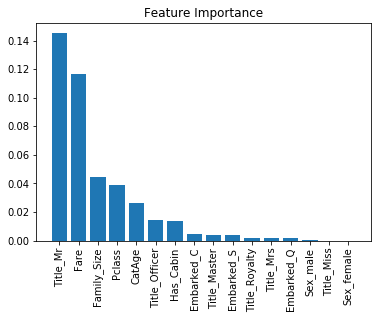

In [39]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [data.columns[i] for i in indices]

# Create plot 
plt.figure()
plt.title("Feature Importance")

# Add bars
plt.bar(range(data.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(data.shape[1]), names, rotation=90)

plt.show()

Assignment To Do 1: Experiment with scaled data. Scale the test data and use decision tree classifier to see if the results in terms of AUC improve. 

In [44]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train_small)
X_train_small_std = sc.transform(X_train_small)
X_test_small_std = sc.transform(X_test_small)

C:\Users\Tanya Yuferova\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Tanya Yuferova\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  """
C:\Users\Tanya Yuferova\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype bool, uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [45]:
dt2 = DecisionTreeClassifier(random_state=42)
dt2.fit(X_train_small_std, y_train_small)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [46]:
cross_val_score(dt2, X_train_small_std, y_train_small, cv=3, scoring="accuracy")

array([0.7752809 , 0.77902622, 0.80827068])

In [47]:
from sklearn.metrics import roc_curve, auc
y_pred_small = dt2.predict(X_test_small_std)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_small, y_pred_small)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7974716202270382

Assignment To Do 2: Continue with the previous exercise and use GridSearchCV to find the best parameter for the desicision tree classifier. You can try to tune other parameters beside 'max_depth' and 'min_samples_leaf'

In [58]:
dt_params_2 = [
   { 'max_depth': [1, 2, 4, 8, 16, 32, 64], 
     'min_samples_leaf' : [1, 2, 3, 4, 5, 6],
     'min_samples_split' : [2, 3, 4],
   },
]

In [59]:
dt_cv_2 = GridSearchCV(estimator=dt2, param_grid=dt_params_2, cv=4)
dt_cv_2.fit(X_train_small_std, y_train_small)

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'max_depth': [1, 2, 4, 8, 16, 32, 64], 'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'min_samples_split': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
cross_val_score(dt_cv_2.best_estimator_, X_train_small_std, y_train_small, cv=3, scoring="accuracy")

array([0.7752809 , 0.82397004, 0.79699248])

In [61]:
print("Optimal params: {}".format(dt_cv_2.best_estimator_))

Optimal params: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')


In [62]:
from sklearn.metrics import roc_curve, auc
y_pred_small = dt_cv_2.best_estimator_.predict(X_test_small_std)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_small, y_pred_small)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7915376676986585

### Use a random forest classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rnd_clf.fit(X_train_small, y_train_small)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [64]:
y_pred_small = rnd_clf.predict(X_test_small)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_small, y_pred_small)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8237874097007224

Prepare prediction results for submission to Kaggle

In [65]:
y_pred = rnd_clf.predict(X_test)

submission = pd.DataFrame({
        "PassengerId": X_test_orig["PassengerId"],
        "Survived": y_pred
    })
submission.to_csv('titanic.csv', index=False)

Assignment To Do 3: Submit the titanic.csv file to Kaggle and record your scores. (Optionaltry using other classifiers from the scikit learn library as well. 

When I uploaded the titanic.csv file on Kaggle I got a score of 0.77511  and it ran for almost 39 seconds.